In [1]:
import numpy as np
import pandas as pd
import uproot
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
#!pip install mplhep
#!pip install lz4 xxhash
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib
matplotlib.rcParams['figure.dpi'] = 96

In [3]:
def load_files(filepaths, treename='Events', filter_name=None, selection=None):
    import glob
    dfs = []
    if not isinstance(filepaths, (list, tuple)):
        filepaths = [filepaths]
    filepaths = sum([glob.glob(fp) for fp in filepaths], [])
    for fp in filepaths:
        df = uproot.open(fp)[treename].arrays(library='pd', filter_name=filter_name)
        if selection is not None:
            df = df.query(selection)
        dfs.append(df)
    return pd.concat(dfs)

In [4]:
def bkg_rej(tpr, fpr, eff=0.5):
    idx = next(idx for idx, v in enumerate(tpr) if v>eff)
#     print('tpr=%.3f, fpr=%.6f, 1/fpr=%.2f'%(tpr[idx], fpr[idx], 1/fpr[idx]))
    rej = 1/fpr[idx]
    return rej

In [5]:
def plot(comp_list, title='ROC Curve', savename='testfig.png', comp_text='', eff_wps=[0.5,]):
    
    colours = {
        "bb vs g" : u'#1f77b4',
        "b vs g" : u'#ff7f0e',
        "cc vs g" : u'#2ca02c',
        "c vs g" : u'#d62728',
        "uds vs g" : u'#9467bd',
        "b vs udsg" : u'#1f77b4',
        "b vs c" : u'#ff7f0e'
    }
    debug = True
    
    aucs = {}
    idx = 0
    f, ax = plt.subplots()
    # for name, cfg in comp_list.items():
    #     if debug: print(name)
    #     if debug: print(cfg)
    #     bkgrejs = {}
    #     sig, bkg = cfg['label']
    #     sel = f"{cfg.get('selection')} & ({sig}==1 | {bkg}==1)"


        
    #     df = load_files(cfg['filepath'], treename=cfg.get('treename', 'Events'), 
    #                     filter_name=cfg.get('filter_name'), selection=sel)
    #     if debug: print(name, cfg['score'], sel, len(df), sep=",")

    #     # if math.isnan(df.eval(cfg['score'])):
    #     #     print("Debugging, score divide by 0")
    #     #     cfg['score'] = '0'


        
    #     y_true = df[sig].values
    #     y_pred = df.eval(cfg['score'])

    #     # Debugging NaN values
    #     y_pred[np.isnan(y_pred)] = 0

    #     fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    #     auc = roc_auc_score(y_true, y_pred)
    #     aucs[idx] = auc
    #     idx += 1
        
    #     colour = [c for l, c in colours.items() if l in name][0]
    #     if debug: print(colour)
    #     style = '-' if "FULL" in name.upper() else '--'
    #     if debug: print(style)

    #     ax.plot(tpr, fpr, style, label='%s (AUC = %.4f)'%(name, auc), color=colour)

    #     for wp in eff_wps:
    #         bkgrejs[wp] = bkg_rej(tpr, fpr, wp)

    #     if debug: print(' - ', name, auc, [bkgrejs[wp] for wp in eff_wps], sep=',')
        
    # #order = dict(sorted(aucs.items(), key=lambda item: item[1])).keys()
    # #handels, labels = plt.gca().get_legend_handles_labels()
    
    # #ax.legend([handels[idx] for idx in order],[labels[idx] for idx in order], loc='best', fontsize=16)
    # ax.legend(bbox_to_anchor=(1.04,1), loc="best")
    # ax.set_yscale('log')
    # ax.set_ylim(1e-5 if auc > 0.999 else 1e-4, 1)
    # ax.set_xlim(0.9 if auc > 0.999 else 0, 1)
    # ax.set_xlabel('Signal efficiency', horizontalalignment='right', x=1.0)
    # ax.set_ylabel('Background efficiency', horizontalalignment='right', y=1.0)
    # ax.text(0.03, 0.95, comp_text, transform=ax.transAxes, fontsize=20, weight='bold')


    for name, cfg in comp_list.items():
        if debug: print(name)
        if debug: print(cfg)
        bkgrejs = {}
        sig, bkg = cfg['label']
        sel = f"{cfg.get('selection')} & ({sig}==1 | {bkg}==1)"


        
        df = load_files(cfg['filepath'], treename=cfg.get('treename', 'Events'), 
                        filter_name=cfg.get('filter_name'), selection=sel)
        if debug: print(name, cfg['score'], sel, len(df), sep=",")

        # if math.isnan(df.eval(cfg['score'])):
        #     print("Debugging, score divide by 0")
        #     cfg['score'] = '0'


        
        y_true = df[sig].values
        y_pred = df.eval(cfg['score'])

        # Debugging NaN values
        y_pred[np.isnan(y_pred)] = 0

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        aucs[idx] = auc
        idx += 1
        
        colour = [c for l, c in colours.items() if l in name][0]
        if debug: print(colour)
        style = '-'
        # style = '-' if "FULL" in name.upper() else '--'
        if debug: print(style)

        ax.plot(fpr, tpr, style, label='%s (AUC = %.4f)'%(name, auc), color=colour)

        for wp in eff_wps:
            bkgrejs[wp] = bkg_rej(tpr, fpr, wp)

        if debug: print(' - ', name, auc, [bkgrejs[wp] for wp in eff_wps], sep=',')
        
    #order = dict(sorted(aucs.items(), key=lambda item: item[1])).keys()
    #handels, labels = plt.gca().get_legend_handles_labels()
    
    #ax.legend([handels[idx] for idx in order],[labels[idx] for idx in order], loc='best', fontsize=16)
    ax.legend(bbox_to_anchor=(1.04,1), loc="best")
    # ax.set_xscale('log')
    ax.set_xlim(1e-5 if auc > 0.999 else 1e-4, 1)
    ax.set_ylim(0.9 if auc > 0.999 else 0, 1)
    ax.set_ylabel('Signal efficiency', horizontalalignment='right', x=1.0)
    ax.set_xlabel('Background efficiency', horizontalalignment='right', y=1.0)
    ax.text(0.03, 0.95, comp_text, transform=ax.transAxes, fontsize=20, weight='bold')
    plt.title(title)
    plt.savefig(savename)
    



In [6]:
# sigs = ["b", "bb", "c", "cc", "uds"]

# algos = {}

# for sig in sigs:
    
#     algos[f'FULL: {sig} vs g'] = {
#         'filepath' : '/home/akobert/ParticleNet/training/output/test0.root',
# #         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
#         #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
#         #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
#         'label' : [f'label_{sig}', 'label_g'],
#         'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
#         'selection' : 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'
#     }

# #     algos[f'PIXEL: {sig} vs g'] = {
# #         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220525-213651_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
#         #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_full.root',
# #         'label' : [f'label_{sig}', 'label_g'],
# #         'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
# #         'selection' : 'jet_pt>50 & jet_eta>-2.5 & jet_eta<2.5'
# #     }

# plot(algos)

b vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_b', 'label_g'], 'score': 'score_label_b/(score_label_b + score_label_g)', 'selection': 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'}
b vs g,score_label_b/(score_label_b + score_label_g),jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5 & (label_b==1 | label_g==1),437313
#ff7f0e
-
 - ,b vs g,0.8623536611887583,[110.41381557510589]
bb vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_bb', 'label_g'], 'score': 'score_label_bb/(score_label_bb + score_label_g)', 'selection': 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'}
bb vs g,score_label_bb/(score_label_bb + score_label_g),jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5 & (label_bb==1 | label_g==1),402099
#1f77b4
-
 - ,bb vs g,0.9856210130923265,[10268.48484848485]
c vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_c', 'label_g'], 'score': 'score_label_c/(score_label_c + score_label_g)', '

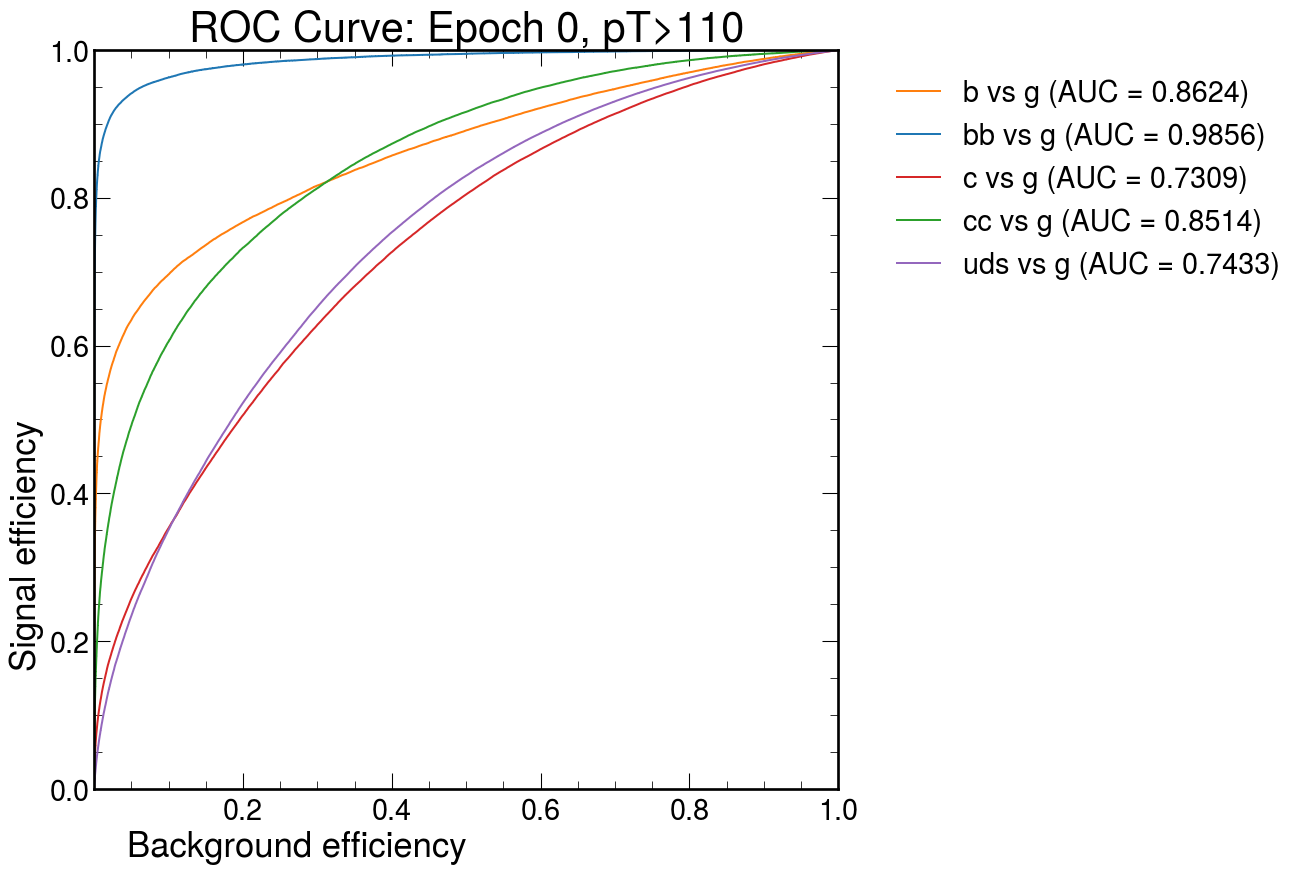

In [7]:
sigs = ["b", "bb", "c", "cc", "uds"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs g'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test1.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'label_{sig}', 'label_g'],
        'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
        'selection' : 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'
    }

#     algos[f'PIXEL: {sig} vs g'] = {
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220525-213651_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_full.root',
#         'label' : [f'label_{sig}', 'label_g'],
#         'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
#         'selection' : 'jet_pt>50 & jet_eta>-2.5 & jet_eta<2.5'
#     }

plot(algos, title='ROC Curve: Epoch 0, pT>110', savename='retrain_epoch0_pt110.png')

b vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_b', 'label_g'], 'score': 'score_label_b/(score_label_b + score_label_g)', 'selection': 'jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5'}
b vs g,score_label_b/(score_label_b + score_label_g),jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5 & (label_b==1 | label_g==1),116638
#ff7f0e
-
 - ,b vs g,0.8458676241273845,[43.07052124397722]
bb vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_bb', 'label_g'], 'score': 'score_label_bb/(score_label_bb + score_label_g)', 'selection': 'jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5'}
bb vs g,score_label_bb/(score_label_bb + score_label_g),jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5 & (label_bb==1 | label_g==1),119765
#1f77b4
-
 - ,bb vs g,0.9881134768691736,[7563.846153846154]
c vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_c', 'label_g'], 'score': 'score_label_c/(score_label_c + score_label_g)', 's

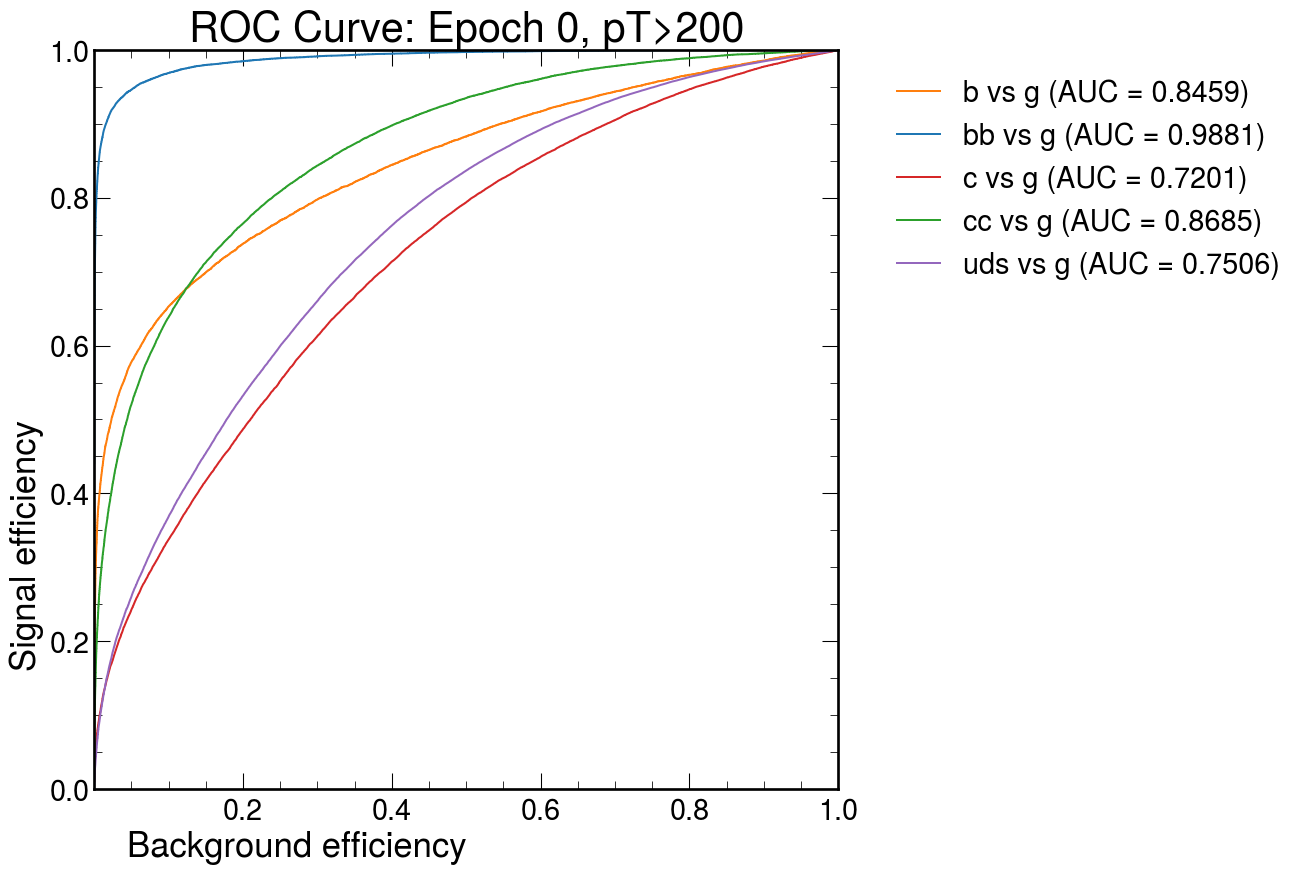

In [8]:
sigs = ["b", "bb", "c", "cc", "uds"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs g'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test1.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'label_{sig}', 'label_g'],
        'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
        'selection' : 'jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5'
    }

#     algos[f'PIXEL: {sig} vs g'] = {
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220525-213651_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_full.root',
#         'label' : [f'label_{sig}', 'label_g'],
#         'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
#         'selection' : 'jet_pt>50 & jet_eta>-2.5 & jet_eta<2.5'
#     }

plot(algos, title='ROC Curve: Epoch 0, pT>200', savename='retrain_epoch0_pt200.png')

b vs g
{'filepath': '/home/akobert/ParticleNet/training/output/standard2.root', 'label': ['label_b', 'label_g'], 'score': 'score_label_b/(score_label_b + score_label_g)', 'selection': 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'}
b vs g,score_label_b/(score_label_b + score_label_g),jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5 & (label_b==1 | label_g==1),1015747
#ff7f0e
-
 - ,b vs g,0.7247038179727853,[7.196160462103676]
bb vs g
{'filepath': '/home/akobert/ParticleNet/training/output/standard2.root', 'label': ['label_bb', 'label_g'], 'score': 'score_label_bb/(score_label_bb + score_label_g)', 'selection': 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'}
bb vs g,score_label_bb/(score_label_bb + score_label_g),jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5 & (label_bb==1 | label_g==1),402099
#1f77b4
-
 - ,bb vs g,0.5477916793822406,[2.2279056923825427]
c vs g
{'filepath': '/home/akobert/ParticleNet/training/output/standard2.root', 'label': ['label_c', 'label_g'], 'score': 'score_label_c/(score_label_c + score

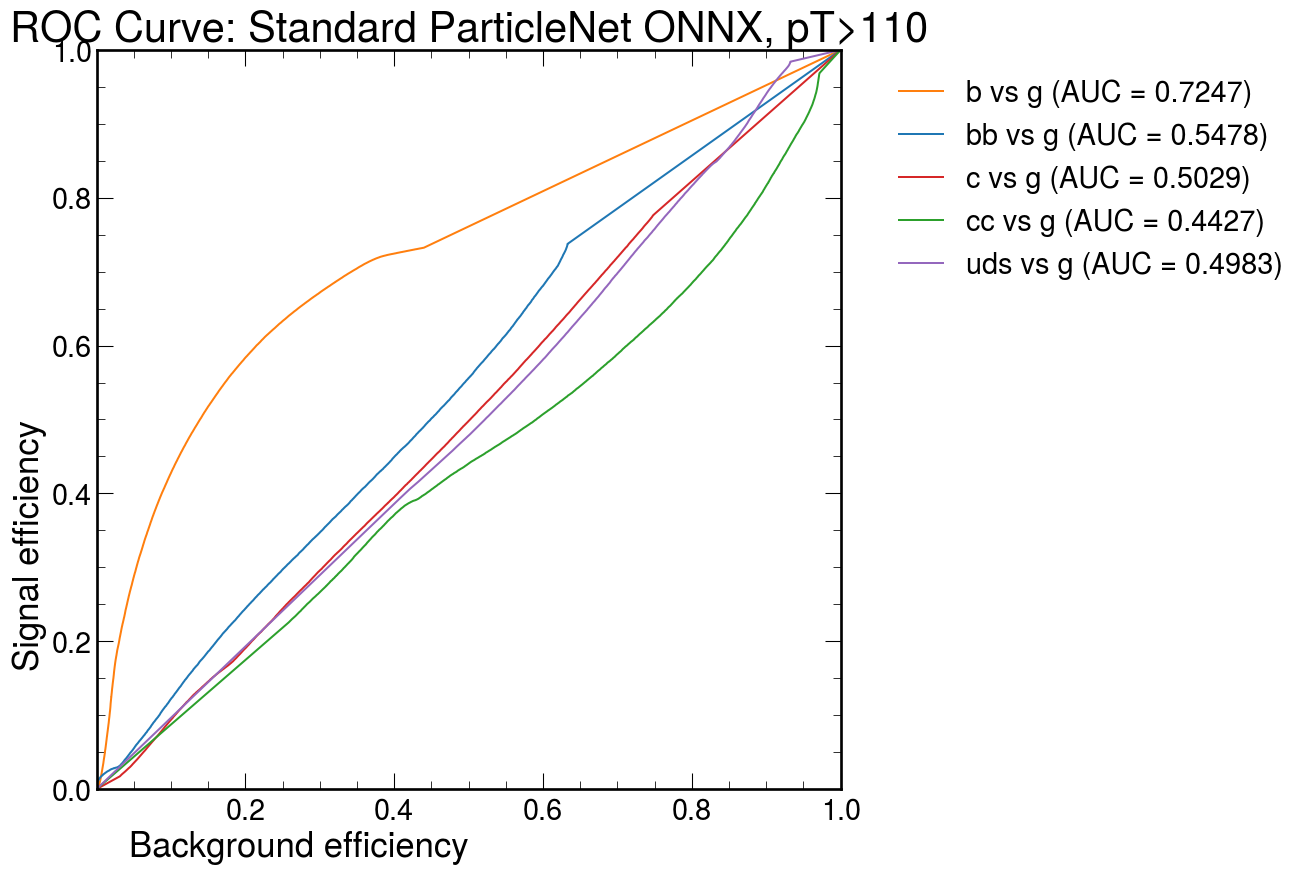

In [9]:
sigs = ["b", "bb", "c", "cc", "uds"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs g'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/standard2.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'label_{sig}', 'label_g'],
        'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
        'selection' : 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'
    }

#     algos[f'PIXEL: {sig} vs g'] = {
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220525-213651_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_full.root',
#         'label' : [f'label_{sig}', 'label_g'],
#         'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
#         'selection' : 'jet_pt>50 & jet_eta>-2.5 & jet_eta<2.5'
#     }

plot(algos, title='ROC Curve: Standard ParticleNet ONNX, pT>110', savename='standard_pt110.png')

b vs g
{'filepath': '/home/akobert/ParticleNet/training/output/standard2.root', 'label': ['label_b', 'label_g'], 'score': 'score_label_b/(score_label_b + score_label_g)', 'selection': 'jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5'}
b vs g,score_label_b/(score_label_b + score_label_g),jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5 & (label_b==1 | label_g==1),306281
#ff7f0e
-
 - ,b vs g,0.7634574591018922,[9.164026095060578]
bb vs g
{'filepath': '/home/akobert/ParticleNet/training/output/standard2.root', 'label': ['label_bb', 'label_g'], 'score': 'score_label_bb/(score_label_bb + score_label_g)', 'selection': 'jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5'}
bb vs g,score_label_bb/(score_label_bb + score_label_g),jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5 & (label_bb==1 | label_g==1),119765
#1f77b4
-
 - ,bb vs g,0.501354388523946,[1.9937145174371451]
c vs g
{'filepath': '/home/akobert/ParticleNet/training/output/standard2.root', 'label': ['label_c', 'label_g'], 'score': 'score_label_c/(score_label_c + score_l

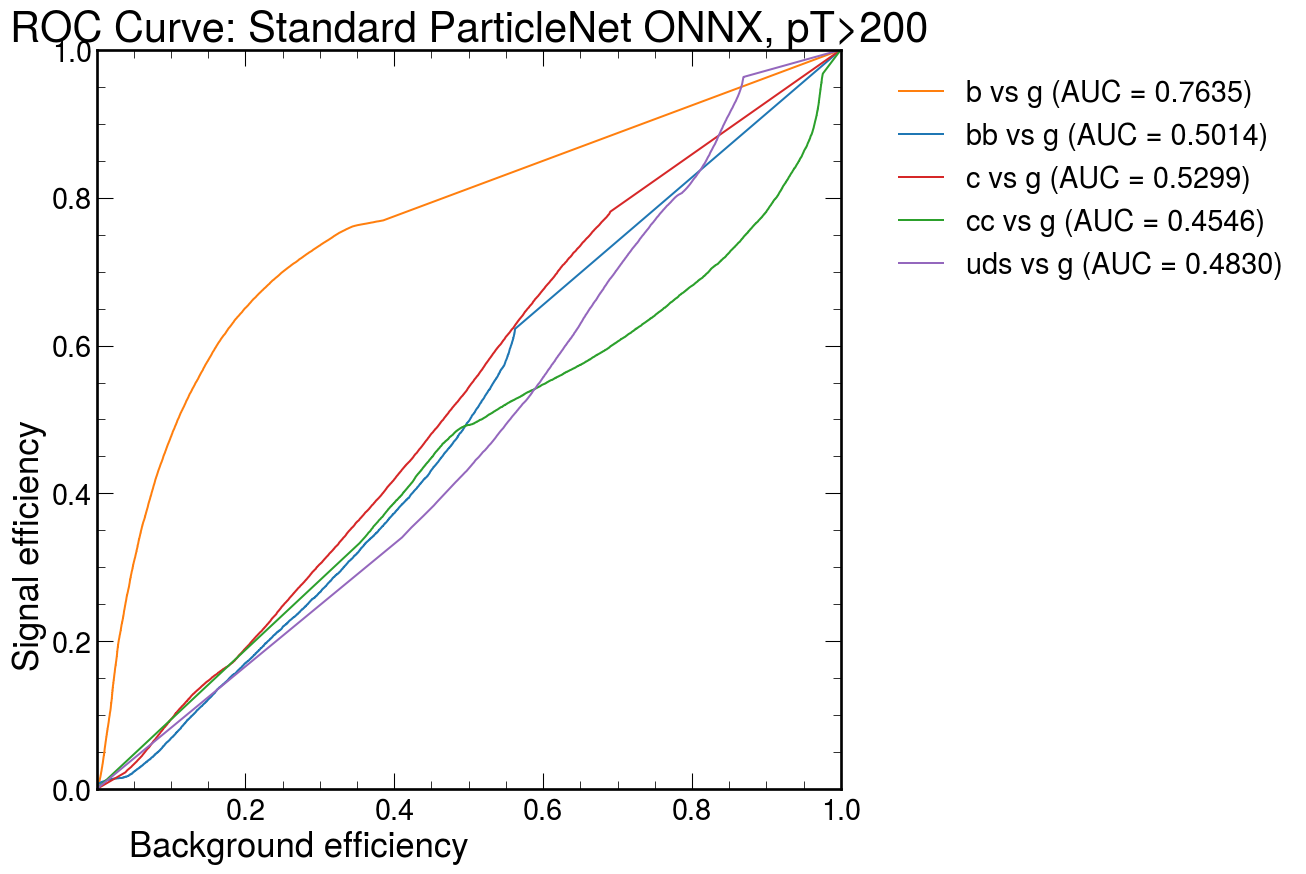

In [10]:
sigs = ["b", "bb", "c", "cc", "uds"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs g'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/standard2.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'label_{sig}', 'label_g'],
        'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
        'selection' : 'jet_pt>200 & jet_eta>-2.5 & jet_eta<2.5'
    }

#     algos[f'PIXEL: {sig} vs g'] = {
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220525-213651_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_full.root',
#         'label' : [f'label_{sig}', 'label_g'],
#         'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
#         'selection' : 'jet_pt>50 & jet_eta>-2.5 & jet_eta<2.5'
#     }

plot(algos, title='ROC Curve: Standard ParticleNet ONNX, pT>200', savename='standard_pt200.png')

In [11]:
# label_sig = "label_b"

# algos = {}

# algos['FULL: b vs udsg'] = {
#     'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
#     'label' : ['{0}'.format(label_sig), 'label_g'],
#     'score' : 'score_{0}/(score_{0} + score_label_uds + score_label_g)'.format(label_sig),
#     'selection' : 'jet_pt>15 & jet_pt<600 & jet_eta>-2.5 & jet_eta<2.5'
# }

# algos['PIXEL: b vs udsg'] = {
#     'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220525-213651_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
#     'label' : ['{0}'.format(label_sig), 'label_g'],
#     'score' : 'score_{0}/(score_{0} + score_label_uds + score_label_g)'.format(label_sig),
#     'selection' : 'jet_pt>15 & jet_pt<600 & jet_eta>-2.5 & jet_eta<2.5'
# }

# algos['FULL: b vs c'] = {
#     'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
#     'label' : ['{0}'.format(label_sig), 'label_c'],
#     'score' : 'score_{0}/(score_{0} + score_label_c)'.format(label_sig),
#     'selection' : 'jet_pt>15 & jet_pt<600 & jet_eta>-2.5 & jet_eta<2.5'
# }

# algos['PIXEL: b vs c'] = {
#     'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220525-213651_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
#     'label' : ['{0}'.format(label_sig), 'label_c'],
#     'score' : 'score_{0}/(score_{0} + score_label_c)'.format(label_sig),
#     'selection' : 'jet_pt>15 & jet_pt<600 & jet_eta>-2.5 & jet_eta<2.5'
# }

# plot(algos)

b vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_b', 'label_g'], 'score': 'score_label_b/(score_label_b + score_label_g)', 'selection': 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'}
b vs g,score_label_b/(score_label_b + score_label_g),jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5 & (label_b==1 | label_g==1),437313
#ff7f0e
-
 - ,b vs g,0.8623536611887583,[110.41381557510589]
bb vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_bb', 'label_g'], 'score': 'score_label_bb/(score_label_bb + score_label_g)', 'selection': 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'}
bb vs g,score_label_bb/(score_label_bb + score_label_g),jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5 & (label_bb==1 | label_g==1),402099
#1f77b4
-
 - ,bb vs g,0.9856210130923265,[10268.48484848485]
c vs g
{'filepath': '/home/akobert/ParticleNet/training/output/test1.root', 'label': ['label_c', 'label_g'], 'score': 'score_label_c/(score_label_c + score_label_g)', '

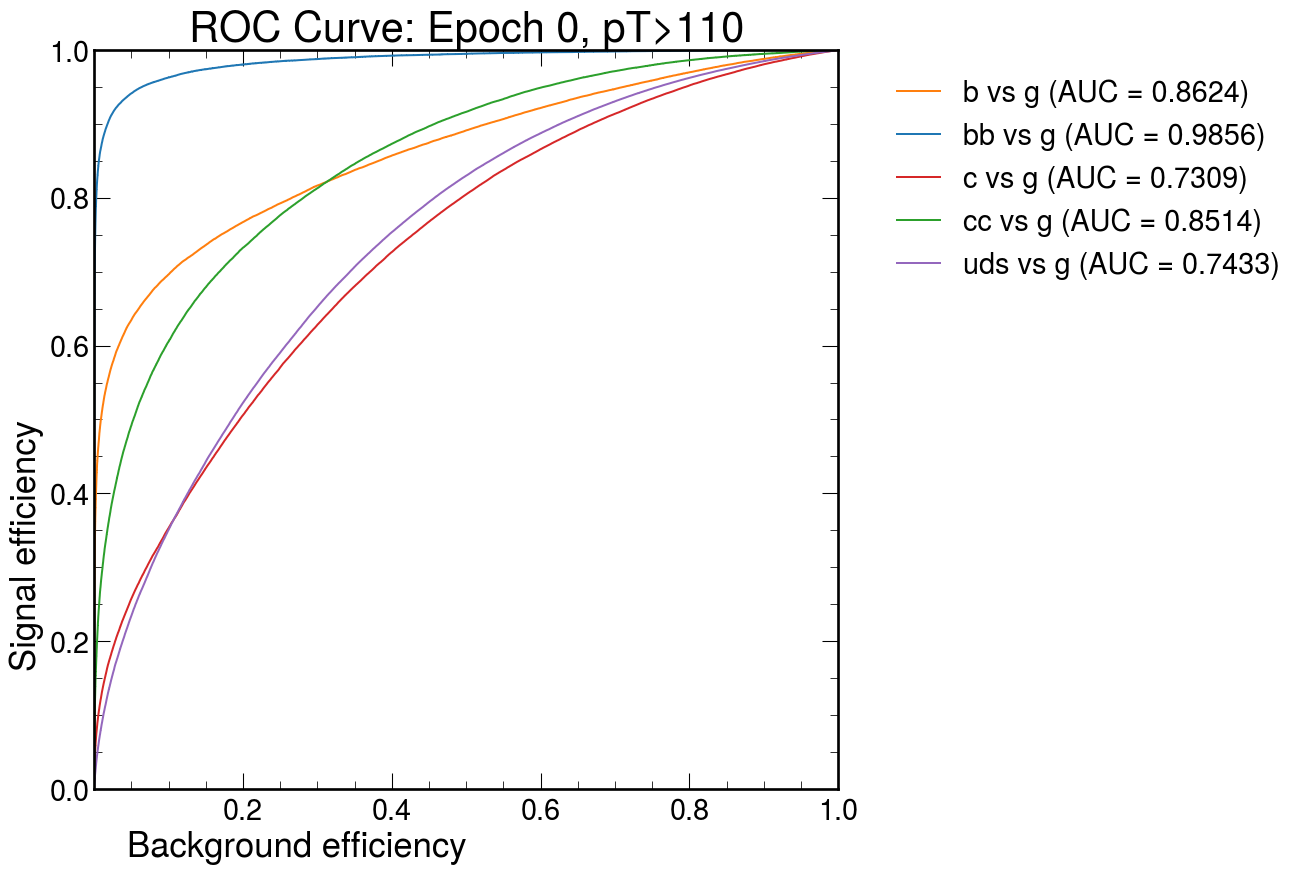

In [7]:
sigs = ["b", "bb", "c", "cc", "uds"]

algos = {}

for sig in sigs:
    
    algos[f'{sig} vs g'] = {
        'filepath' : '/home/akobert/ParticleNet/training/output/test6_M50.root',
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220531-072338_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220529-202709_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_pixel.root',
        'label' : [f'label_{sig}', 'label_g'],
        'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
        'selection' : 'jet_pt>110 & jet_eta>-2.5 & jet_eta<2.5'
    }

#     algos[f'PIXEL: {sig} vs g'] = {
#         'filepath' : '/eos/user/a/adlintul/scouting/particlenet/kubeflow/outputs/train_pixelOnly_vs_Full-20220525-213651_particlenet_pf_ranger_lr0.005_batch512/predict_output/pred.root',
        #'filepath' : '/eos/user/p/phmaster/data/adelina_tmp/predict_output_full.root',
#         'label' : [f'label_{sig}', 'label_g'],
#         'score' : f'score_label_{sig}/(score_label_{sig} + score_label_g)',
#         'selection' : 'jet_pt>50 & jet_eta>-2.5 & jet_eta<2.5'
#     }

plot(algos, title='ROC Curve: Epoch 0, pT>110', savename='retrain_epoch0_pt110.png')